In [1]:
# Import the necessary libraries
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import tensorflow as tf
import matplotlib.pyplot as plt
import os
import cv2

2025-02-17 07:11:52.122643: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-02-17 07:11:52.895501: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/usr/local/cuda-11.5/lib64:/usr/local/cuda/extras/CUPTI/lib64
2025-02-17 07:11:52.895612: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/usr/local/cuda-11.5/lib64:/usr/local/cuda/extras/CUPTI/li

In [ ]:
input_path = '/home/diya/Projects/super_resolution/flow_super_resolution/dataset/'
output_path = '/home/diya/Projects/super_resolution/flow_super_resolution/outputs/bilinear/'
if not os.path.exists(output_path):
    os.makedirs(output_path)

In [3]:
# Set the random seed for reproducibility
tf.keras.utils.set_random_seed(42)

In [4]:
# Read the file ids and file names for train and val data
train_df = pd.read_csv(input_path+'train.csv')
val_df= pd.read_csv(input_path+'val.csv')

# Print the first 5 rows of pandas dataframe
train_df.head()

,id,rho_filename,ux_filename,uy_filename,uz_filename
0,-5634614311666768042,RHO_kgm-3_id-5634614311666768042.dat,UX_ms-1_id-5634614311666768042.dat,UY_ms-1_id-5634614311666768042.dat,UZ_ms-1_id-5634614311666768042.dat
1,-2337253536160728058,RHO_kgm-3_id-2337253536160728058.dat,UX_ms-1_id-2337253536160728058.dat,UY_ms-1_id-2337253536160728058.dat,UZ_ms-1_id-2337253536160728058.dat
2,-7056668419406715714,RHO_kgm-3_id-7056668419406715714.dat,UX_ms-1_id-7056668419406715714.dat,UY_ms-1_id-7056668419406715714.dat,UZ_ms-1_id-7056668419406715714.dat
3,-9138984573931233156,RHO_kgm-3_id-9138984573931233156.dat,UX_ms-1_id-9138984573931233156.dat,UY_ms-1_id-9138984573931233156.dat,UZ_ms-1_id-9138984573931233156.dat
4,2699082921033192879,RHO_kgm-3_id2699082921033192879.dat,UX_ms-1_id2699082921033192879.dat,UY_ms-1_id2699082921033192879.dat,UZ_ms-1_id2699082921033192879.dat


Text(0.5, 1.0, 'Z-Velocity')

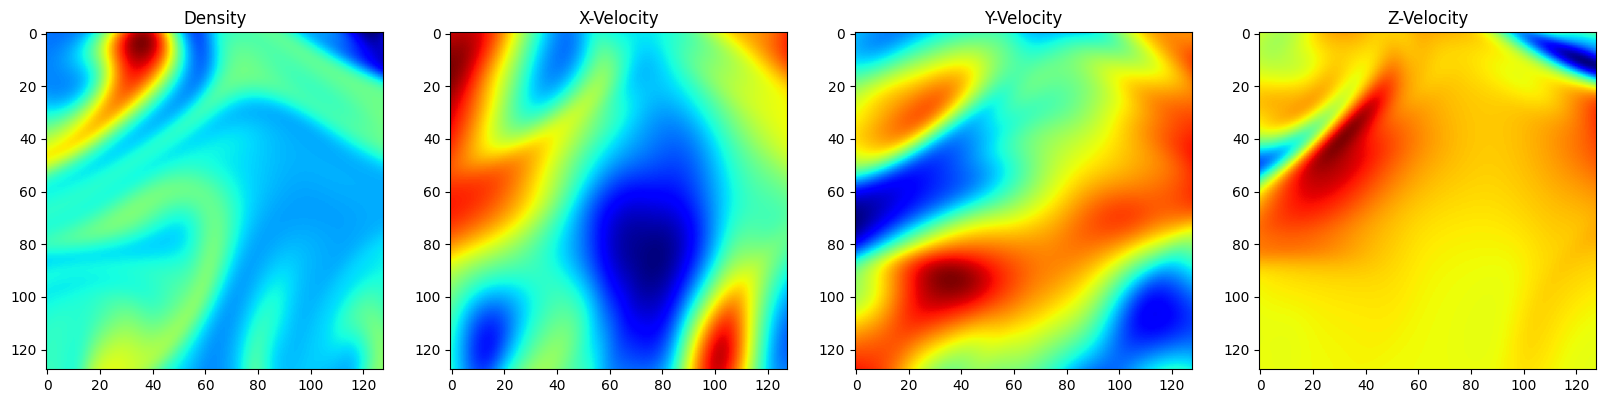

In [5]:
# Plot the High-Resolution (HR) train labels

idx = 20
data_path = input_path+"flowfields/HR/train"
RHO_filename = train_df['rho_filename'][idx]
UX_filename = train_df['ux_filename'][idx]
UY_filename = train_df['uy_filename'][idx]
UZ_filename = train_df['uz_filename'][idx]
RHO = np.fromfile(data_path + "/" + RHO_filename, dtype="<f4")
UX = np.fromfile(data_path + "/" + UX_filename, dtype="<f4")
UY = np.fromfile(data_path + "/" + UY_filename, dtype="<f4")
UZ = np.fromfile(data_path + "/" + UZ_filename, dtype="<f4")

fig, axs = plt.subplots(1, 4, figsize=(20, 5))
axs[0].imshow(RHO.reshape(128, 128), cmap='jet')
axs[0].set_title('Density')
axs[1].imshow(UX.reshape(128, 128), cmap='jet')
axs[1].set_title('X-Velocity')
axs[2].imshow(UY.reshape(128, 128), cmap='jet')
axs[2].set_title('Y-Velocity')
axs[3].imshow(UZ.reshape(128, 128), cmap='jet')
axs[3].set_title('Z-Velocity')

Text(0.5, 1.0, 'UZ')

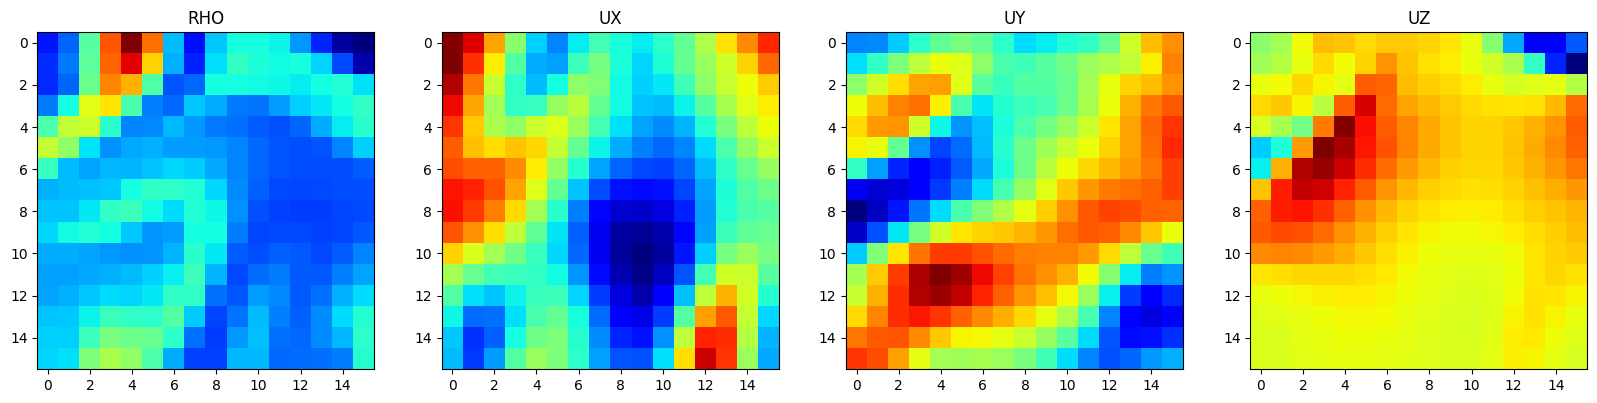

In [6]:
# Plot the low-resolution (LR) train features

id = 20
data_path = input_path+"flowfields/LR/train"
RHO_filename = train_df['rho_filename'][id]
UX_filename = train_df['ux_filename'][id]
UY_filename = train_df['uy_filename'][id]
UZ_filename = train_df['uz_filename'][id]
RHO = np.fromfile(data_path + "/" + RHO_filename, dtype="<f4")
UX = np.fromfile(data_path + "/" + UX_filename, dtype="<f4")
UY = np.fromfile(data_path + "/" + UY_filename, dtype="<f4")
UZ = np.fromfile(data_path + "/" + UZ_filename, dtype="<f4")

fig, axs = plt.subplots(1, 4, figsize=(20, 5))
axs[0].imshow(RHO.reshape(16, 16), cmap='jet')
axs[0].set_title('RHO')
axs[1].imshow(UX.reshape(16, 16), cmap='jet')
axs[1].set_title('UX')
axs[2].imshow(UY.reshape(16, 16), cmap='jet')
axs[2].set_title('UY')
axs[3].imshow(UZ.reshape(16, 16), cmap='jet')
axs[3].set_title('UZ')

In [7]:
# Set up the Data Pipeline

# Data Loader
def getXY(idx,csv_file,mode = "train"):
    LR_path = input_path + "flowfields/LR/" + mode
    HR_path = input_path + "flowfields/HR/" + mode
    #input
    rho_i = np.fromfile(LR_path + "/" + csv_file['rho_filename'][idx], dtype="<f4").reshape(16,16)
    ux_i = np.fromfile(LR_path + "/" + csv_file['ux_filename'][idx], dtype="<f4").reshape(16,16)
    uy_i = np.fromfile(LR_path + "/" + csv_file['uy_filename'][idx], dtype="<f4").reshape(16,16)
    uz_i = np.fromfile(LR_path + "/" + csv_file['uz_filename'][idx], dtype="<f4").reshape(16,16)
    #output
    rho_o = np.fromfile(HR_path + "/" + csv_file['rho_filename'][idx], dtype="<f4").reshape(128,128)
    ux_o = np.fromfile(HR_path + "/" + csv_file['ux_filename'][idx], dtype="<f4").reshape(128,128)
    uy_o = np.fromfile(HR_path + "/" + csv_file['uy_filename'][idx], dtype="<f4").reshape(128,128)
    uz_o = np.fromfile(HR_path + "/" + csv_file['uz_filename'][idx], dtype="<f4").reshape(128,128)
    
    X = tf.stack([rho_i,ux_i,uy_i,uz_i],axis=2)
    Y = tf.stack([rho_o,ux_o,uy_o,uz_o],axis=2)
    
    return [X,Y]

def getTrainXY(idx):
    return getXY(idx,train_df.reset_index().to_dict(orient='list'),mode = "train")

def getValXY(idx):
    return getXY(idx,val_df.reset_index().to_dict(orient='list'),mode = "val")

In [8]:
nfile = len(train_df)
X_train = []
Y_train = []

for i in range(nfile):
    X,Y = getTrainXY(i)
    X_train.append(X)
    Y_train.append(Y)
X_train = tf.stack(X_train)
Y_train = tf.stack(Y_train)
X_mean = tf.reduce_mean(X_train,axis=0)
X_std = tf.math.reduce_std(X_train,axis=0)
Y_mean = tf.reduce_mean(Y_train,axis=0)
Y_std = tf.math.reduce_std(Y_train,axis=0)
X_mean.shape,X_std.shape,Y_mean.shape,Y_std.shape

2025-02-17 07:11:55.596590: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-02-17 07:11:55.693137: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 31106 MB memory:  -> device: 0, name: Quadro GV100, pci bus id: 0000:b3:00.0, compute capability: 7.0


(TensorShape([16, 16, 4]),
 TensorShape([16, 16, 4]),
 TensorShape([128, 128, 4]),
 TensorShape([128, 128, 4]))

In [ ]:
def bilinear_interpolation_INTERLINEAR(image, scale_factor):
    """
    Perform bilinear interpolation to upscale an image using OpenCV's INTER_CUBIC method.
    
    Parameters:
    image (numpy.ndarray): Input image as a 2D numpy array.
    scale_factor (int): Factor by which to increase the image size.
    
    Returns:
    numpy.ndarray: Upscaled image.
    """
    
    # Get the original image dimensions
    height, width = image.shape
    
    # Calculate new dimensions
    new_height = height * scale_factor
    new_width = width * scale_factor
    
    # Perform bilinear interpolation using cv2.resize with INTER_CUBIC
    upscaled_image = cv2.resize(image, (new_width, new_height), interpolation=cv2.INTER_LINEAR)
    
    return upscaled_image

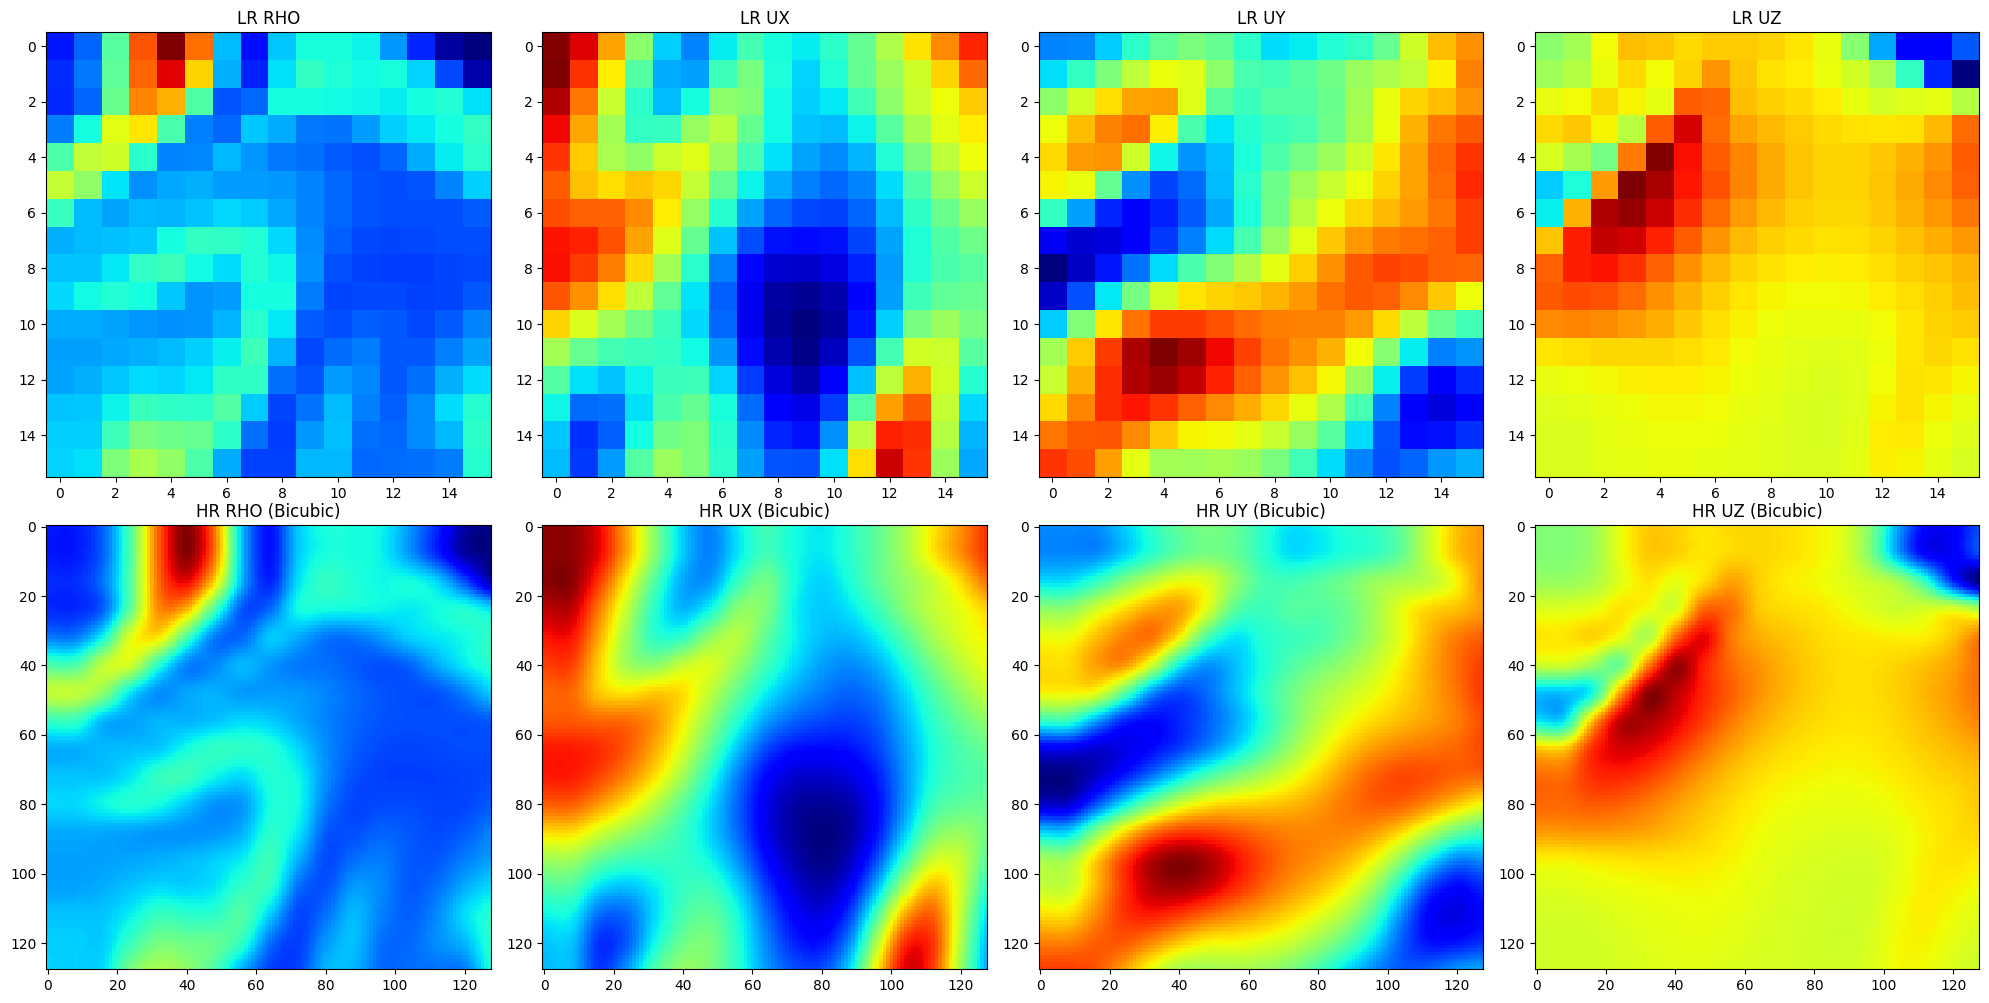

In [ ]:
scale_factor = 8  # From 16x16 to 128x128

# Load LR images 
lr_images = [RHO, UX, UY, UZ]
lr_images = [img.reshape(16, 16) for img in lr_images]

# Perform bilinear interpolation
hr_images = [bilinear_interpolation_INTERLINEAR(img, scale_factor) for img in lr_images]

# Visualize results
titles = ['RHO', 'UX', 'UY', 'UZ']
fig, axs = plt.subplots(2, 4, figsize=(20, 10))

for i in range(4):
    axs[0, i].imshow(lr_images[i], cmap='jet')
    axs[0, i].set_title(f'LR {titles[i]}')
    axs[1, i].imshow(hr_images[i], cmap='jet')
    axs[1, i].set_title(f'HR {titles[i]} (Bilinear)')

plt.tight_layout()
plt.show()

In [13]:
def load_hr_images_train(csv_file, idx, input_path):
    """
    Load high-resolution images and format them for comparison.
    
    Parameters:
    csv_file (pandas.DataFrame): DataFrame containing filenames.
    idx (int): Index of the image set to load.
    input_path (str): Base path to the image files.
    
    Returns:
    list: List of numpy arrays, each representing an HR image.
    """
    HR_path = input_path + "flowfields/HR/train"
    
    # Load HR images
    rho_o = np.fromfile(HR_path + "/" + csv_file['rho_filename'][idx], dtype="<f4").reshape(128, 128)
    ux_o = np.fromfile(HR_path + "/" + csv_file['ux_filename'][idx], dtype="<f4").reshape(128, 128)
    uy_o = np.fromfile(HR_path + "/" + csv_file['uy_filename'][idx], dtype="<f4").reshape(128, 128)
    uz_o = np.fromfile(HR_path + "/" + csv_file['uz_filename'][idx], dtype="<f4").reshape(128, 128)
    
    return [rho_o, ux_o, uy_o, uz_o]

In [14]:
idx = 20  
hr_ground_truth = load_hr_images_train(train_df, idx, input_path)



In [15]:
def get_data_range(images):
    min_val = min(np.min(img) for img in images)
    max_val = max(np.max(img) for img in images)
    return min_val, max_val

# Get the data range for both predicted and ground truth images
pred_range = get_data_range(hr_images)
true_range = get_data_range(hr_ground_truth)

# Use the wider of the two ranges
data_min = min(pred_range[0], true_range[0])
data_max = max(pred_range[1], true_range[1])
data_range = data_max - data_min

print(f"Data range: {data_min} to {data_max}")

Data range: -39.12812423706055 to 140.875732421875


In [16]:
from skimage.metrics import peak_signal_noise_ratio

def calculate_mse(img1, img2):
    return np.mean((img1 - img2) ** 2)

def calculate_psnr(img1, img2, data_range):
    return peak_signal_noise_ratio(img1, img2, data_range=data_range)

# Calculate MSE and PSNR for each image type
for i, (pred, true) in enumerate(zip(hr_images, hr_ground_truth)):
    mse = calculate_mse(pred, true)
    psnr = calculate_psnr(pred, true, data_range=data_range)
    print(f"Image {i}: MSE = {mse:.4f}, PSNR = {psnr:.4f} dB")

Image 0: MSE = 0.0000, PSNR = 115.2589 dB
Image 1: MSE = 36.0705, PSNR = 29.5341 dB
Image 2: MSE = 35.8504, PSNR = 29.5607 dB
Image 3: MSE = 1.3786, PSNR = 43.7113 dB


In [17]:
from skimage.metrics import structural_similarity as ssim

def calculate_ssim(img1, img2, data_range):
    return ssim(img1, img2, data_range=data_range)

# Assuming images are normalized between 0 and 1
data_range = 1.0

for i, (pred, true) in enumerate(zip(hr_images, hr_ground_truth)):
    similarity = calculate_ssim(pred, true, data_range)
    print(f"Image {i}: SSIM = {similarity:.4f}")


Image 0: SSIM = 1.0000
Image 1: SSIM = 0.7467
Image 2: SSIM = 0.3839
Image 3: SSIM = 0.5466


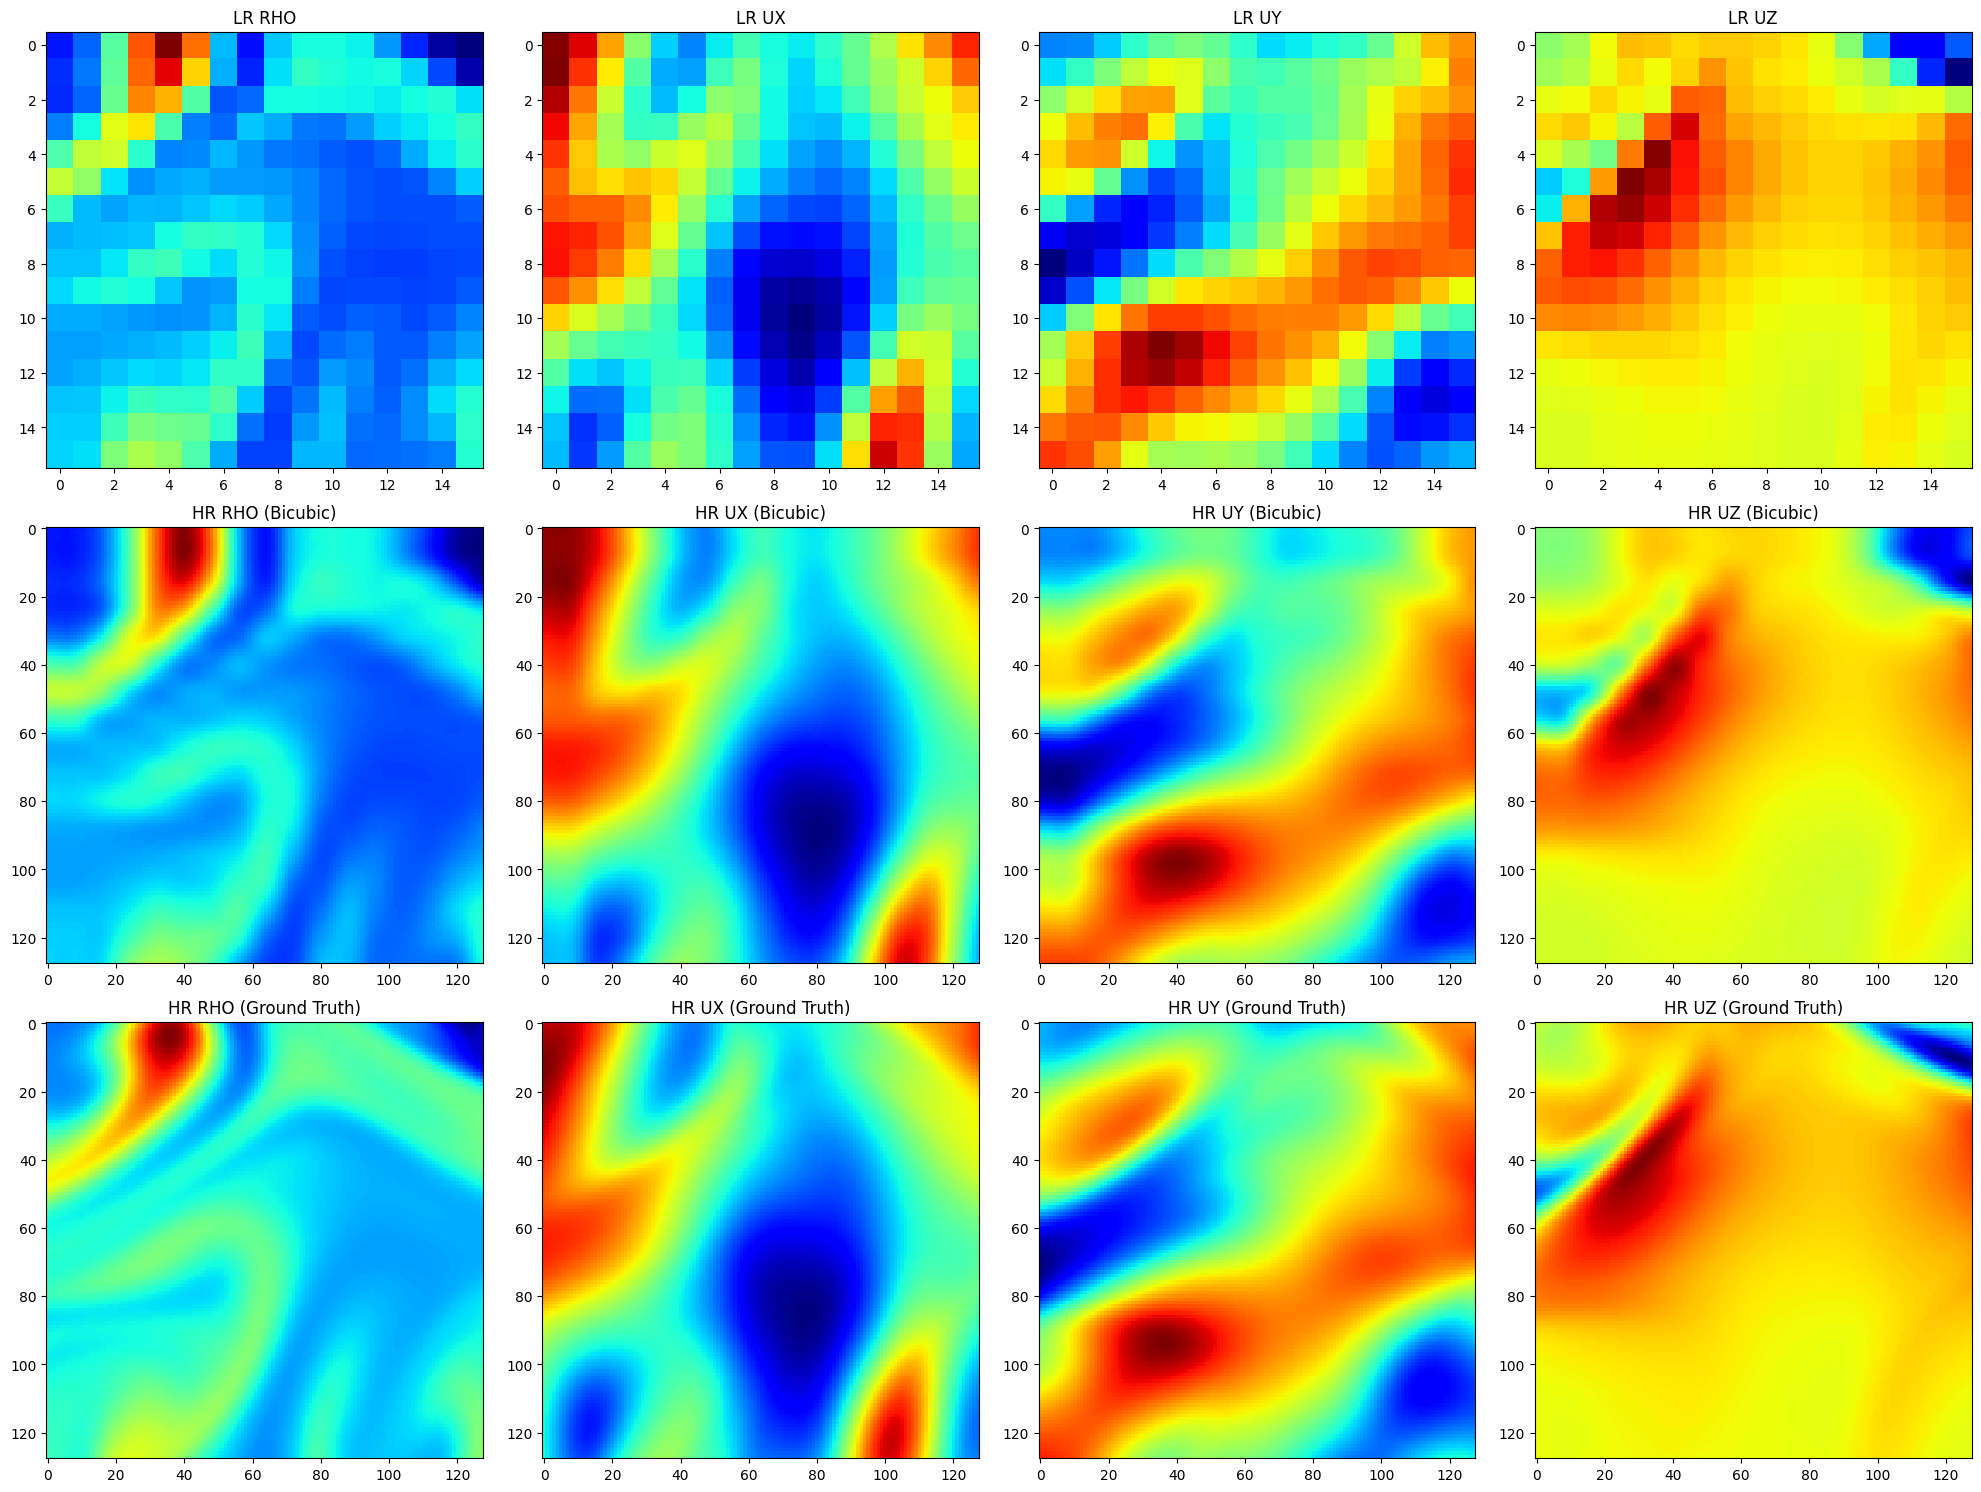

In [ ]:
fig, axs = plt.subplots(3, 4, figsize=(20, 15))
titles = ['RHO', 'UX', 'UY', 'UZ']

for i in range(4):
    axs[0, i].imshow(lr_images[i], cmap='jet')
    axs[0, i].set_title(f'LR {titles[i]}')
    axs[1, i].imshow(hr_images[i], cmap='jet')
    axs[1, i].set_title(f'HR {titles[i]} (Bilinear)')
    axs[2, i].imshow(hr_ground_truth[i], cmap='jet')
    axs[2, i].set_title(f'HR {titles[i]} (Ground Truth)')

plt.tight_layout()
plt.show()

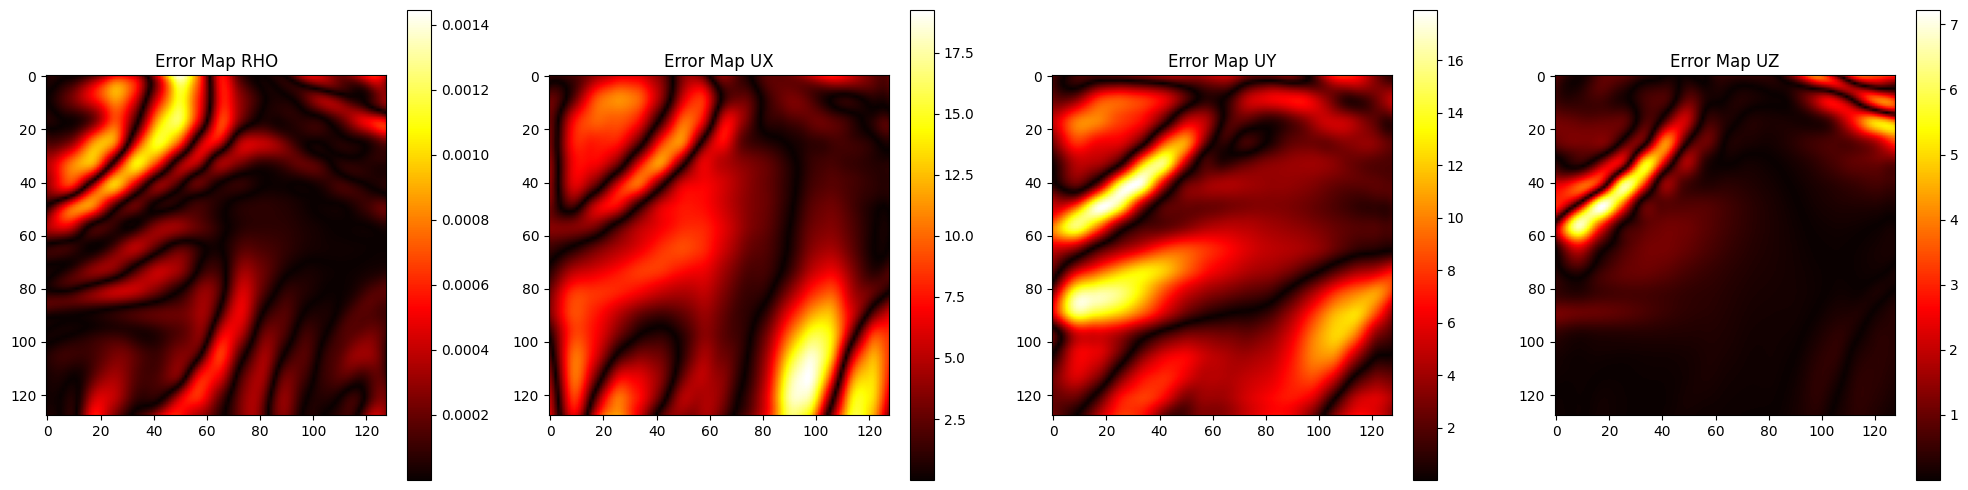

In [19]:
fig, axs = plt.subplots(1, 4, figsize=(20, 5))

for i in range(4):
    error = np.abs(hr_images[i] - hr_ground_truth[i])
    im = axs[i].imshow(error, cmap='hot')
    axs[i].set_title(f'Error Map {titles[i]}')
    fig.colorbar(im, ax=axs[i])

plt.tight_layout()
plt.show()

In [20]:
for i, (pred, true) in enumerate(zip(hr_images, hr_ground_truth)):
    print(f"\nStatistics for {titles[i]}:")
    print(f"Predicted - Mean: {np.mean(pred):.4f}, Std: {np.std(pred):.4f}")
    print(f"Ground Truth - Mean: {np.mean(true):.4f}, Std: {np.std(true):.4f}")


Statistics for RHO:
Predicted - Mean: 0.1785, Std: 0.0005
Ground Truth - Mean: 0.1785, Std: 0.0006

Statistics for UX:
Predicted - Mean: 98.3208, Std: 16.8717
Ground Truth - Mean: 97.6644, Std: 16.6329

Statistics for UY:
Predicted - Mean: -2.3797, Std: 13.7940
Ground Truth - Mean: -1.8664, Std: 14.1362

Statistics for UZ:
Predicted - Mean: 0.8542, Std: 2.1564
Ground Truth - Mean: 0.9491, Std: 2.1935


Text(0.5, 1.0, 'Z-Velocity')

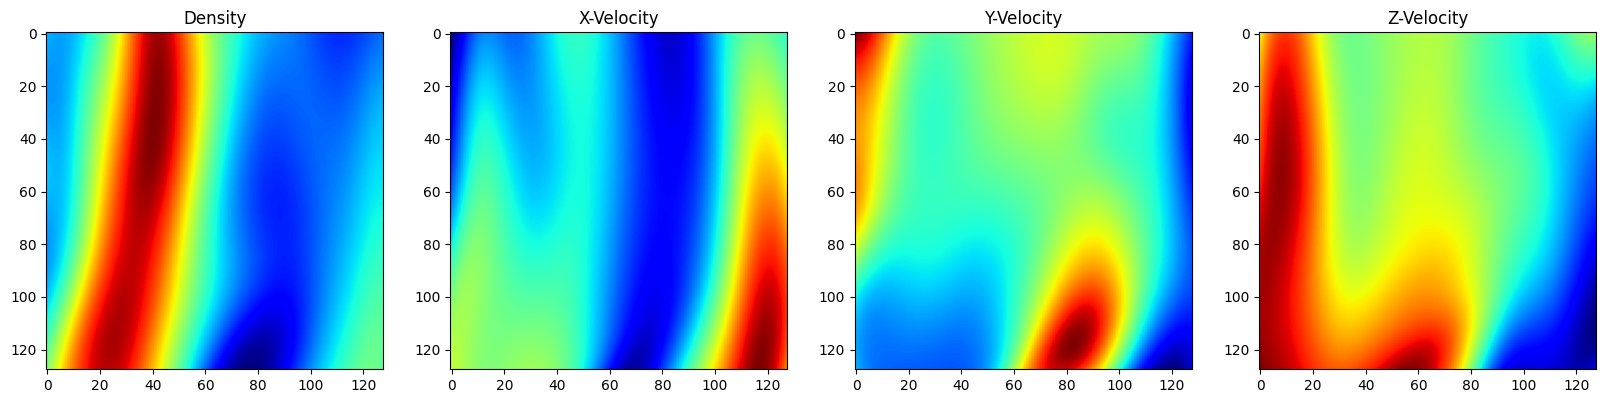

In [21]:
# Plot the HR val labels

idx = 20
data_path = input_path+"flowfields/HR/val"
RHO_filename = val_df['rho_filename'][idx]
UX_filename = val_df['ux_filename'][idx]
UY_filename = val_df['uy_filename'][idx]
UZ_filename = val_df['uz_filename'][idx]
RHO = np.fromfile(data_path + "/" + RHO_filename, dtype="<f4")
UX = np.fromfile(data_path + "/" + UX_filename, dtype="<f4")
UY = np.fromfile(data_path + "/" + UY_filename, dtype="<f4")
UZ = np.fromfile(data_path + "/" + UZ_filename, dtype="<f4")

fig, axs = plt.subplots(1, 4, figsize=(20, 5))
axs[0].imshow(RHO.reshape(128, 128), cmap='jet')
axs[0].set_title('Density')
axs[1].imshow(UX.reshape(128, 128), cmap='jet')
axs[1].set_title('X-Velocity')
axs[2].imshow(UY.reshape(128, 128), cmap='jet')
axs[2].set_title('Y-Velocity')
axs[3].imshow(UZ.reshape(128, 128), cmap='jet')
axs[3].set_title('Z-Velocity')


Text(0.5, 1.0, 'UZ')

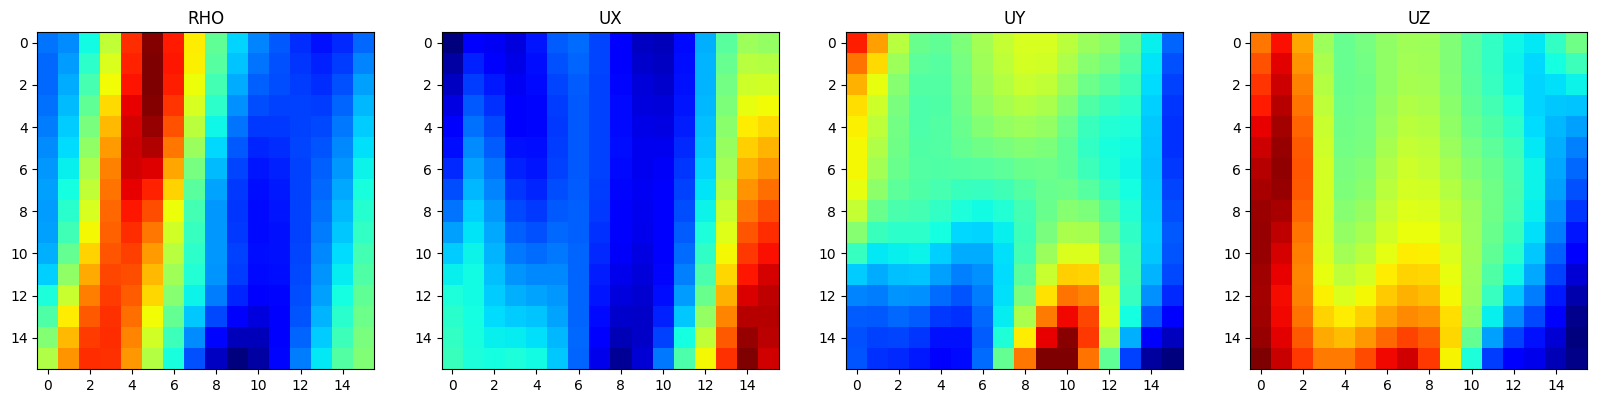

In [22]:
# Plot the LR val features

idx = 20
data_path = input_path+"flowfields/LR/val"
RHO_filename = val_df['rho_filename'][idx]
UX_filename = val_df['ux_filename'][idx]
UY_filename = val_df['uy_filename'][idx]
UZ_filename = val_df['uz_filename'][idx]
RHO = np.fromfile(data_path + "/" + RHO_filename, dtype="<f4")
UX = np.fromfile(data_path + "/" + UX_filename, dtype="<f4")
UY = np.fromfile(data_path + "/" + UY_filename, dtype="<f4")
UZ = np.fromfile(data_path + "/" + UZ_filename, dtype="<f4")

fig, axs = plt.subplots(1, 4, figsize=(20, 5))
axs[0].imshow(RHO.reshape(16, 16), cmap='jet')
axs[0].set_title('RHO')
axs[1].imshow(UX.reshape(16, 16), cmap='jet')
axs[1].set_title('UX')
axs[2].imshow(UY.reshape(16, 16), cmap='jet')
axs[2].set_title('UY')
axs[3].imshow(UZ.reshape(16, 16), cmap='jet')
axs[3].set_title('UZ')

In [23]:
# Set up the Data Pipeline

# Data Loader
def getXY(idx,csv_file,mode = "val"):
    LR_path = input_path + "flowfields/LR/" + mode
    HR_path = input_path + "flowfields/HR/" + mode
    #input
    rho_i = np.fromfile(LR_path + "/" + csv_file['rho_filename'][idx], dtype="<f4").reshape(16,16)
    ux_i = np.fromfile(LR_path + "/" + csv_file['ux_filename'][idx], dtype="<f4").reshape(16,16)
    uy_i = np.fromfile(LR_path + "/" + csv_file['uy_filename'][idx], dtype="<f4").reshape(16,16)
    uz_i = np.fromfile(LR_path + "/" + csv_file['uz_filename'][idx], dtype="<f4").reshape(16,16)
    #output
    rho_o = np.fromfile(HR_path + "/" + csv_file['rho_filename'][idx], dtype="<f4").reshape(128,128)
    ux_o = np.fromfile(HR_path + "/" + csv_file['ux_filename'][idx], dtype="<f4").reshape(128,128)
    uy_o = np.fromfile(HR_path + "/" + csv_file['uy_filename'][idx], dtype="<f4").reshape(128,128)
    uz_o = np.fromfile(HR_path + "/" + csv_file['uz_filename'][idx], dtype="<f4").reshape(128,128)
    
    X = tf.stack([rho_i,ux_i,uy_i,uz_i],axis=2)
    Y = tf.stack([rho_o,ux_o,uy_o,uz_o],axis=2)
    
    return [X,Y]

def getValXY(idx):
    return getXY(idx,val_df.reset_index().to_dict(orient='list'),mode = "val")

In [24]:
nfile = len(val_df)
X_val = []
Y_val = []

# Process the data in batches to avoid Resource Allocation Error

for i in range(nfile):
    X,Y = getValXY(i)
    X_val.append(X)
    Y_val.append(Y)
X_val = tf.stack(X_val)
Y_val = tf.stack(Y_val)
X_mean = tf.reduce_mean(X_val,axis=0)
X_std = tf.math.reduce_std(X_val,axis=0)
Y_mean = tf.reduce_mean(Y_val,axis=0)
Y_std = tf.math.reduce_std(Y_val,axis=0)
X_mean.shape,X_std.shape,Y_mean.shape,Y_std.shape

(TensorShape([16, 16, 4]),
 TensorShape([16, 16, 4]),
 TensorShape([128, 128, 4]),
 TensorShape([128, 128, 4]))

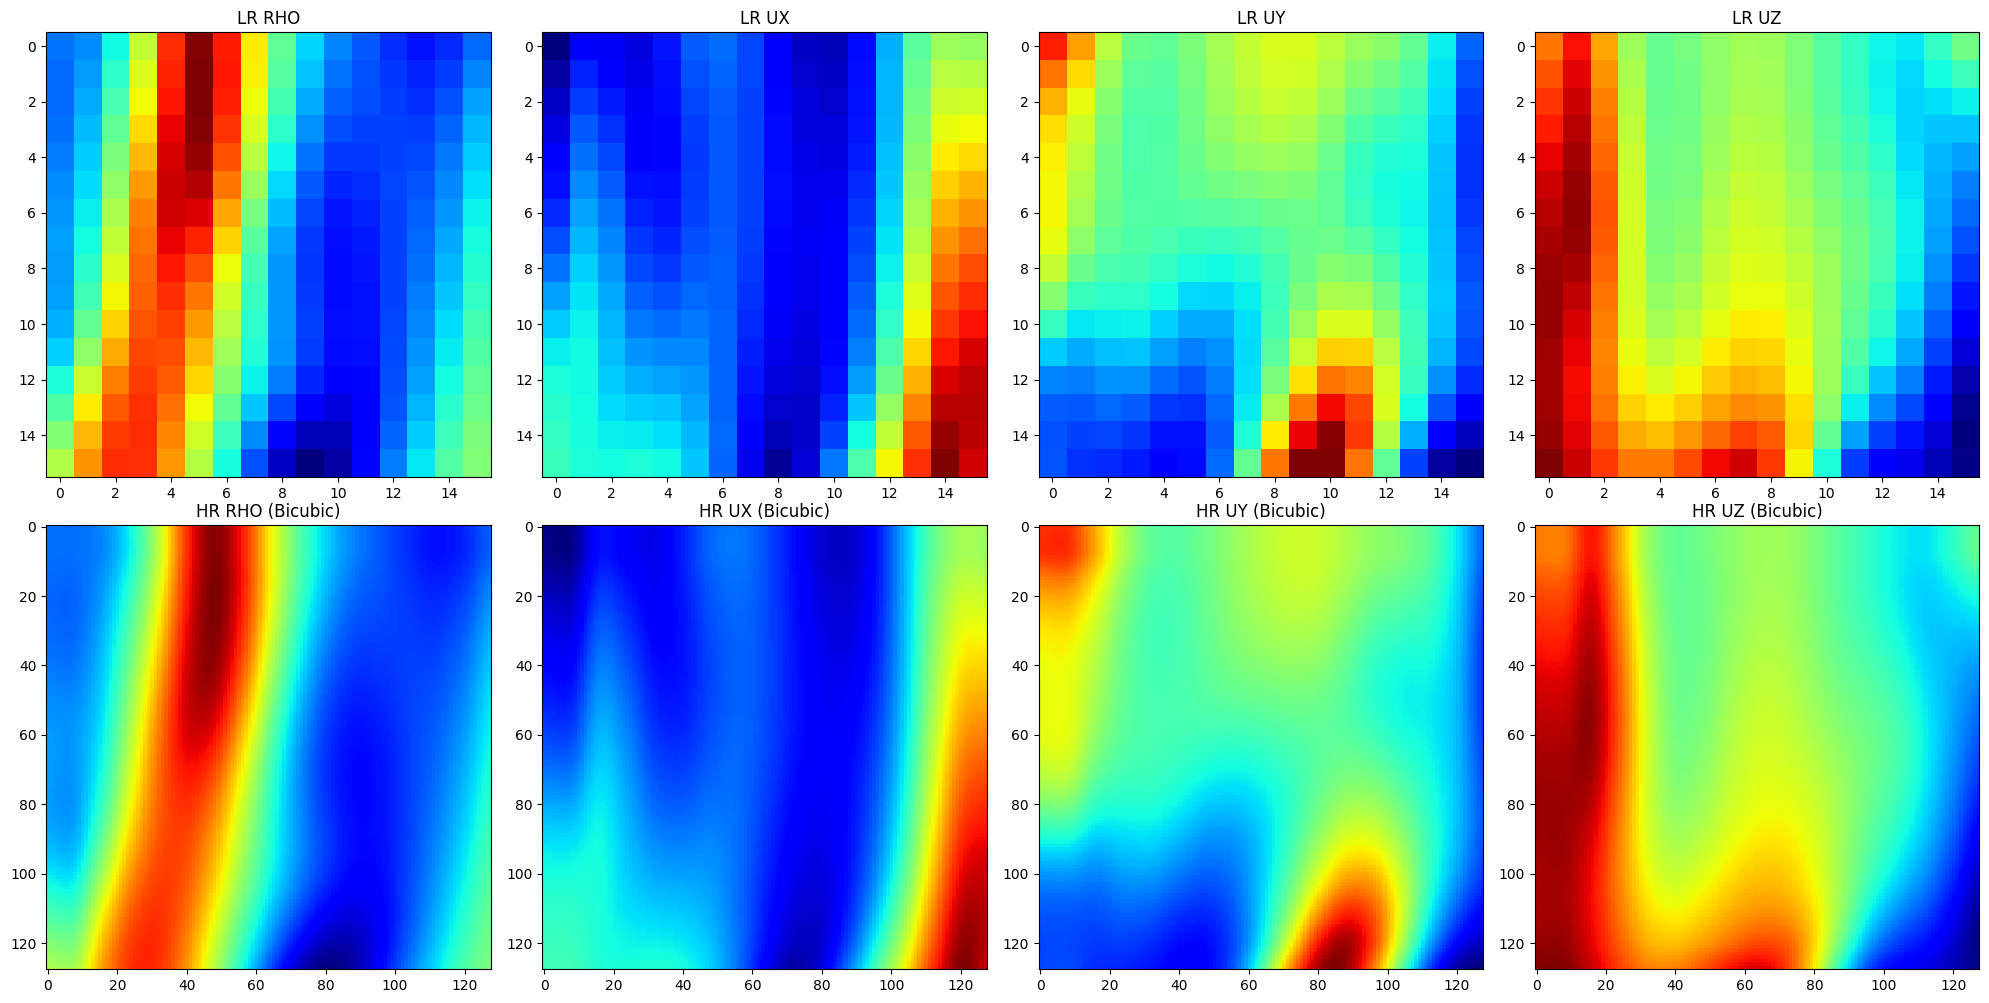

In [ ]:
scale_factor = 8  # From 16x16 to 128x128

# Load LR images 
lr_images = [RHO, UX, UY, UZ]
lr_images = [img.reshape(16, 16) for img in lr_images]

# Perform bilinear interpolation
hr_images = [bilinear_interpolation_INTERLINEAR(img, scale_factor) for img in lr_images]

# Visualize results
titles = ['RHO', 'UX', 'UY', 'UZ']
fig, axs = plt.subplots(2, 4, figsize=(20, 10))

for i in range(4):
    axs[0, i].imshow(lr_images[i], cmap='jet')
    axs[0, i].set_title(f'LR {titles[i]}')
    axs[1, i].imshow(hr_images[i], cmap='jet')
    axs[1, i].set_title(f'HR {titles[i]} (Bilinear)')

plt.tight_layout()
plt.show()

In [26]:
def load_hr_images_val(csv_file, idx, input_path):
    """
    Load high-resolution images and format them for comparison.
    
    Parameters:
    csv_file (pandas.DataFrame): DataFrame containing filenames.
    idx (int): Index of the image set to load.
    input_path (str): Base path to the image files.
    
    Returns:
    list: List of numpy arrays, each representing an HR image.
    """
    HR_path = input_path + "flowfields/HR/val"
    
    # Load HR images
    rho_o = np.fromfile(HR_path + "/" + csv_file['rho_filename'][idx], dtype="<f4").reshape(128, 128)
    ux_o = np.fromfile(HR_path + "/" + csv_file['ux_filename'][idx], dtype="<f4").reshape(128, 128)
    uy_o = np.fromfile(HR_path + "/" + csv_file['uy_filename'][idx], dtype="<f4").reshape(128, 128)
    uz_o = np.fromfile(HR_path + "/" + csv_file['uz_filename'][idx], dtype="<f4").reshape(128, 128)
    
    return [rho_o, ux_o, uy_o, uz_o]

In [27]:
idx = 20  
hr_ground_truth = load_hr_images_val(val_df, idx, input_path)

In [28]:
def get_data_range(images):
    min_val = min(np.min(img) for img in images)
    max_val = max(np.max(img) for img in images)
    return min_val, max_val

# Get the data range for both predicted and ground truth images
pred_range = get_data_range(hr_images)
true_range = get_data_range(hr_ground_truth)

# Use the wider of the two ranges
data_min = min(pred_range[0], true_range[0])
data_max = max(pred_range[1], true_range[1])
data_range = data_max - data_min

print(f"Data range: {data_min} to {data_max}")

Data range: -4.243868350982666 to 111.63898401396727


In [29]:
from skimage.metrics import peak_signal_noise_ratio

def calculate_mse(img1, img2):
    return np.mean((img1 - img2) ** 2)

def calculate_psnr(img1, img2, data_range):
    return peak_signal_noise_ratio(img1, img2, data_range=data_range)

# Calculate MSE and PSNR for each image type
for i, (pred, true) in enumerate(zip(hr_images, hr_ground_truth)):
    mse = calculate_mse(pred, true)
    psnr = calculate_psnr(pred, true, data_range=data_range)
    print(f"Image {i}: MSE = {mse:.4f}, PSNR = {psnr:.4f} dB")

Image 0: MSE = 0.0000, PSNR = 101.4782 dB
Image 1: MSE = 1.9338, PSNR = 38.4162 dB
Image 2: MSE = 0.2199, PSNR = 47.8577 dB
Image 3: MSE = 0.1940, PSNR = 48.4030 dB


In [30]:
# Visual similarity between the predicted and ground truth images

from skimage.metrics import structural_similarity as ssim

def calculate_ssim(img1, img2, data_range):
    return ssim(img1, img2, data_range=data_range)

# Assuming images are normalized between 0 and 1
data_range = 1.0

for i, (pred, true) in enumerate(zip(hr_images, hr_ground_truth)):
    similarity = calculate_ssim(pred, true, data_range)
    print(f"Image {i}: SSIM = {similarity:.4f}")
    

Image 0: SSIM = 1.0000
Image 1: SSIM = 0.6574
Image 2: SSIM = 0.6041
Image 3: SSIM = 0.5874


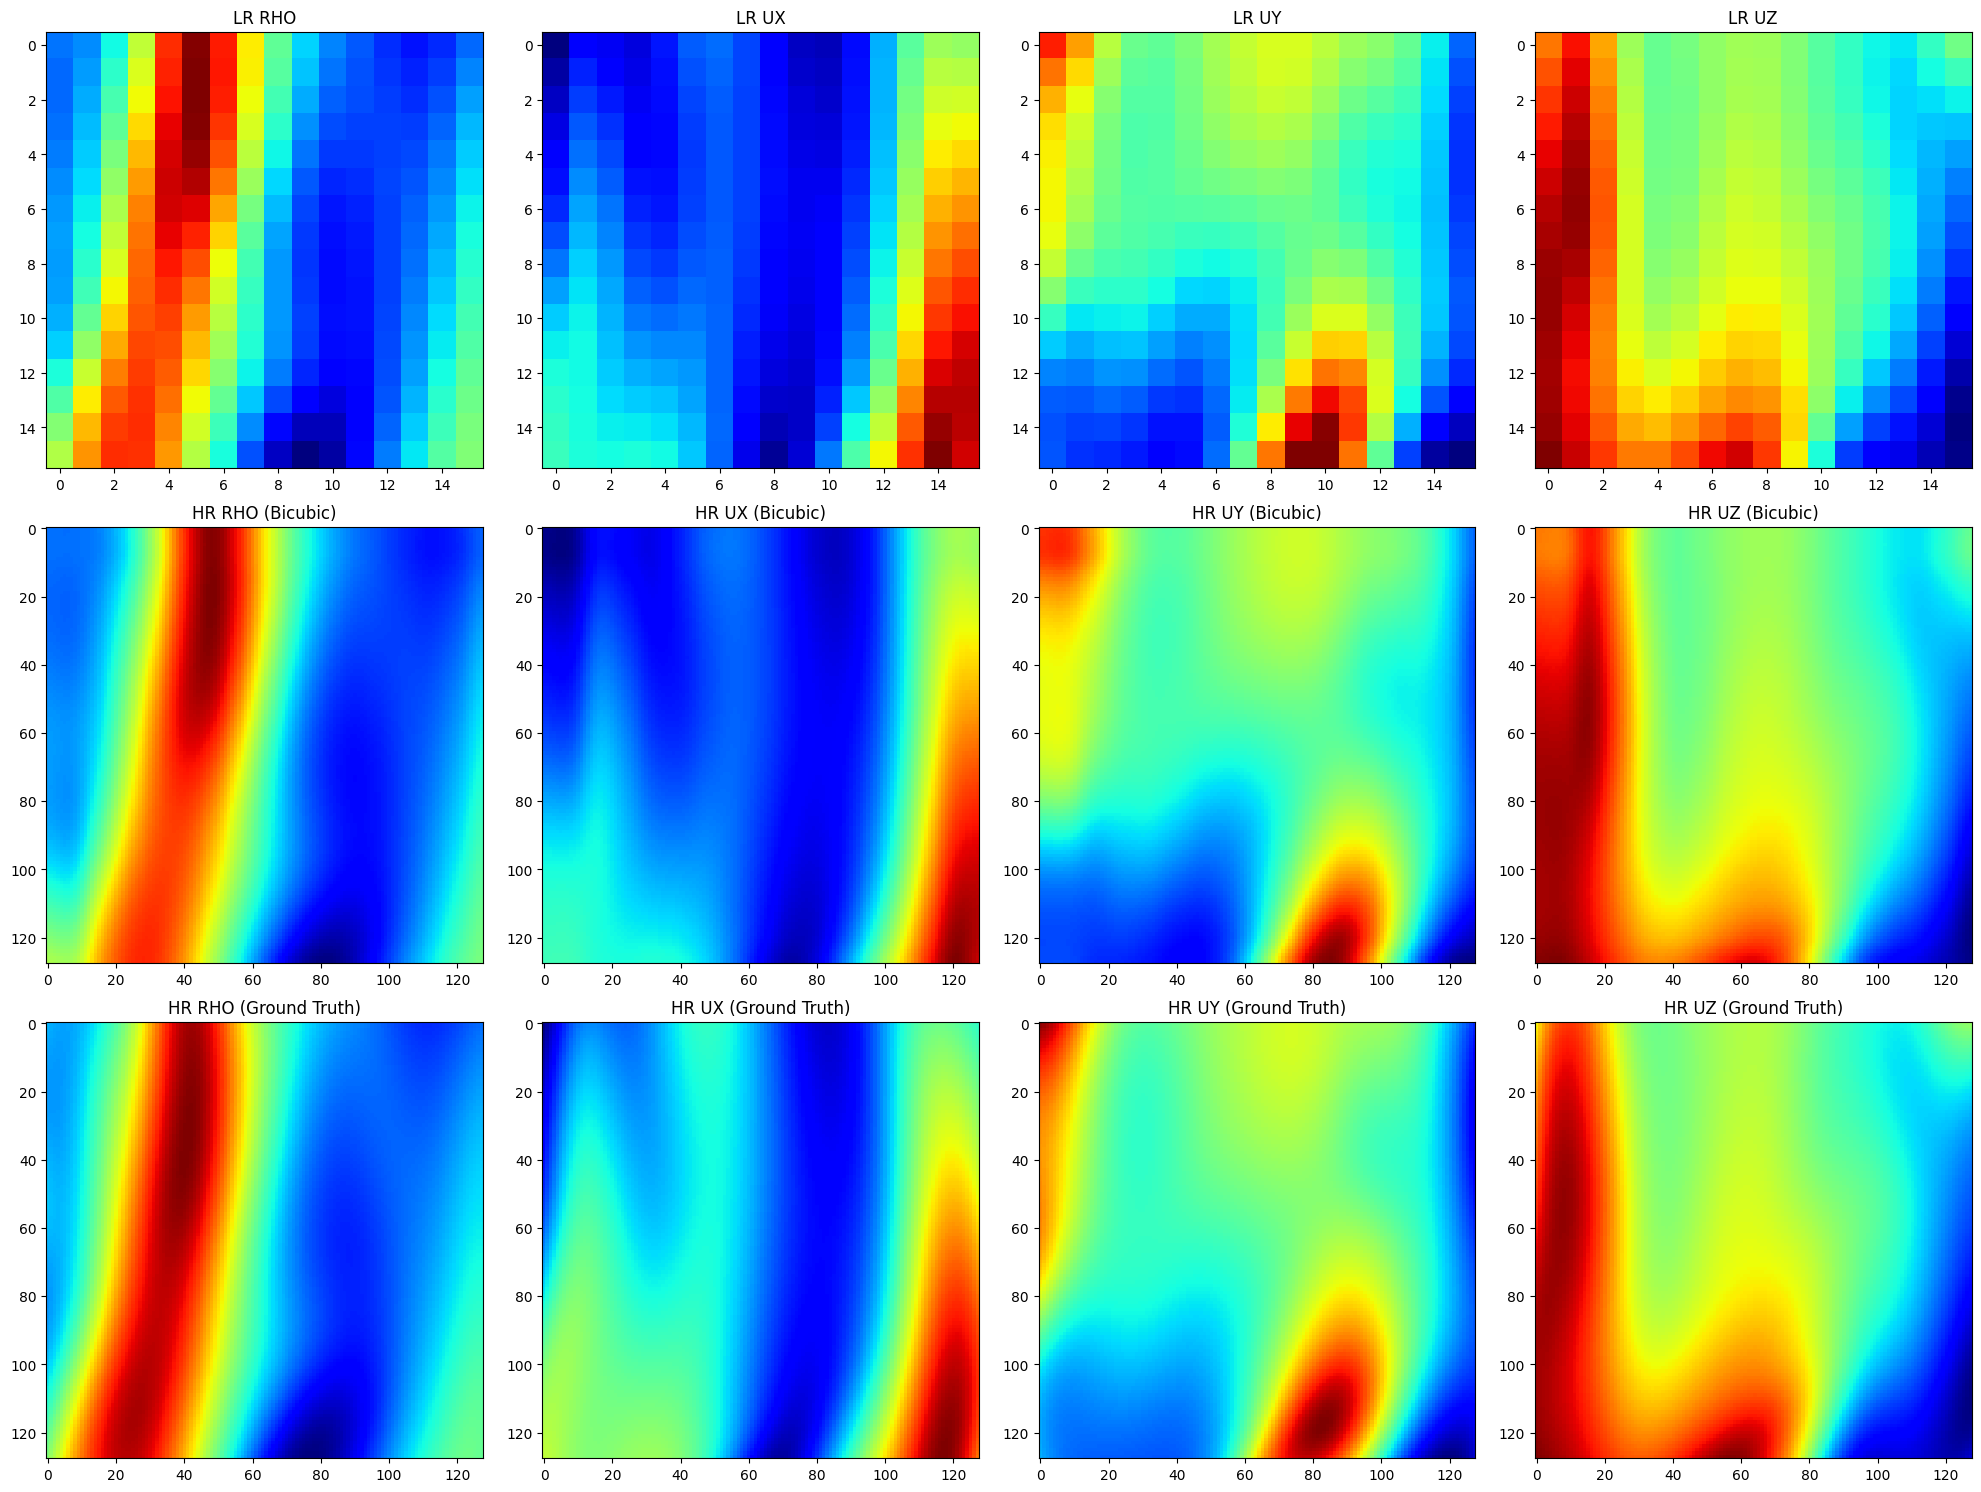

In [ ]:
# Plots for the HR and LR images

fig, axs = plt.subplots(3, 4, figsize=(20, 15))
titles = ['RHO', 'UX', 'UY', 'UZ']

for i in range(4):
    axs[0, i].imshow(lr_images[i], cmap='jet')
    axs[0, i].set_title(f'LR {titles[i]}')
    axs[1, i].imshow(hr_images[i], cmap='jet')
    axs[1, i].set_title(f'HR {titles[i]} (Bilinear)')
    axs[2, i].imshow(hr_ground_truth[i], cmap='jet')
    axs[2, i].set_title(f'HR {titles[i]} (Ground Truth)')
    
plt.tight_layout()

plt.show()


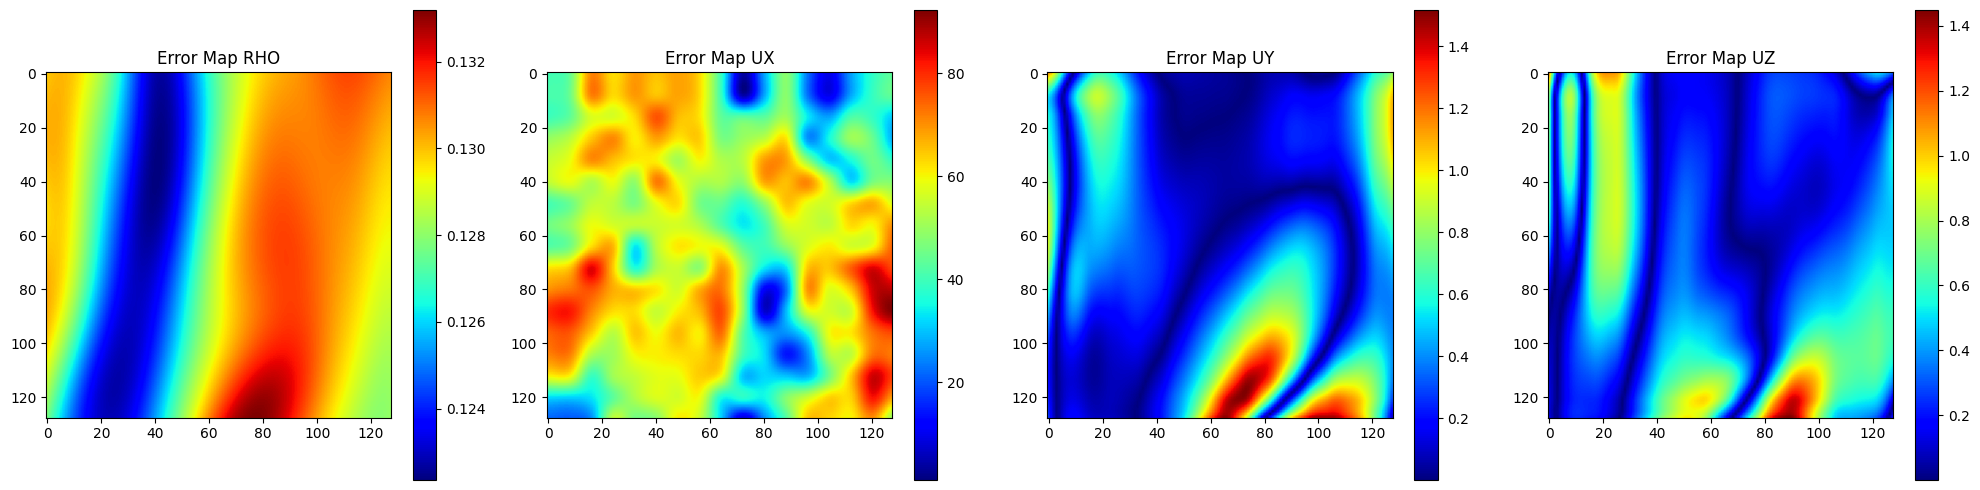

: 

In [ ]:
fig, axs = plt.subplots(1, 4, figsize=(20, 5))

for i in range(4):
    error = np.abs(hr_images[i] - hr_ground_truth[i])
    im = axs[i].imshow(error, cmap='jet')
    axs[i].set_title(f'Error Map {titles[i]}')
    fig.colorbar(im, ax=axs[i])

plt.tight_layout()
plt.show()

In [33]:
for i, (pred, true) in enumerate(zip(hr_images, hr_ground_truth)):
    print(f"\nStatistics for {titles[i]}:")
    print(f"Predicted - Mean: {np.mean(pred):.4f}, Std: {np.std(pred):.4f}")
    print(f"Ground Truth - Mean: {np.mean(true):.4f}, Std: {np.std(true):.4f}")


Statistics for RHO:
Predicted - Mean: 0.1781, Std: 0.0026
Ground Truth - Mean: 0.1782, Std: 0.0029

Statistics for UX:
Predicted - Mean: 97.5932, Std: 4.0929
Ground Truth - Mean: 97.9573, Std: 3.9142

Statistics for UY:
Predicted - Mean: -0.7071, Std: 0.9621
Ground Truth - Mean: -0.7465, Std: 1.1568

Statistics for UZ:
Predicted - Mean: 0.4809, Std: 1.6660
Ground Truth - Mean: 0.3335, Std: 1.8121


In [34]:
test_df= pd.read_csv(input_path+'test.csv')

test_df.head()

,id,rho_filename,ux_filename,uy_filename,uz_filename
0,-657116647631363807,RHO_kgm-3_id-657116647631363807.dat,UX_ms-1_id-657116647631363807.dat,UY_ms-1_id-657116647631363807.dat,UZ_ms-1_id-657116647631363807.dat
1,7483162365939134796,RHO_kgm-3_id7483162365939134796.dat,UX_ms-1_id7483162365939134796.dat,UY_ms-1_id7483162365939134796.dat,UZ_ms-1_id7483162365939134796.dat
2,-6212758420087317096,RHO_kgm-3_id-6212758420087317096.dat,UX_ms-1_id-6212758420087317096.dat,UY_ms-1_id-6212758420087317096.dat,UZ_ms-1_id-6212758420087317096.dat
3,-1825935182480952214,RHO_kgm-3_id-1825935182480952214.dat,UX_ms-1_id-1825935182480952214.dat,UY_ms-1_id-1825935182480952214.dat,UZ_ms-1_id-1825935182480952214.dat
4,-1859240836295259171,RHO_kgm-3_id-1859240836295259171.dat,UX_ms-1_id-1859240836295259171.dat,UY_ms-1_id-1859240836295259171.dat,UZ_ms-1_id-1859240836295259171.dat


Text(0.5, 1.0, 'UZ')

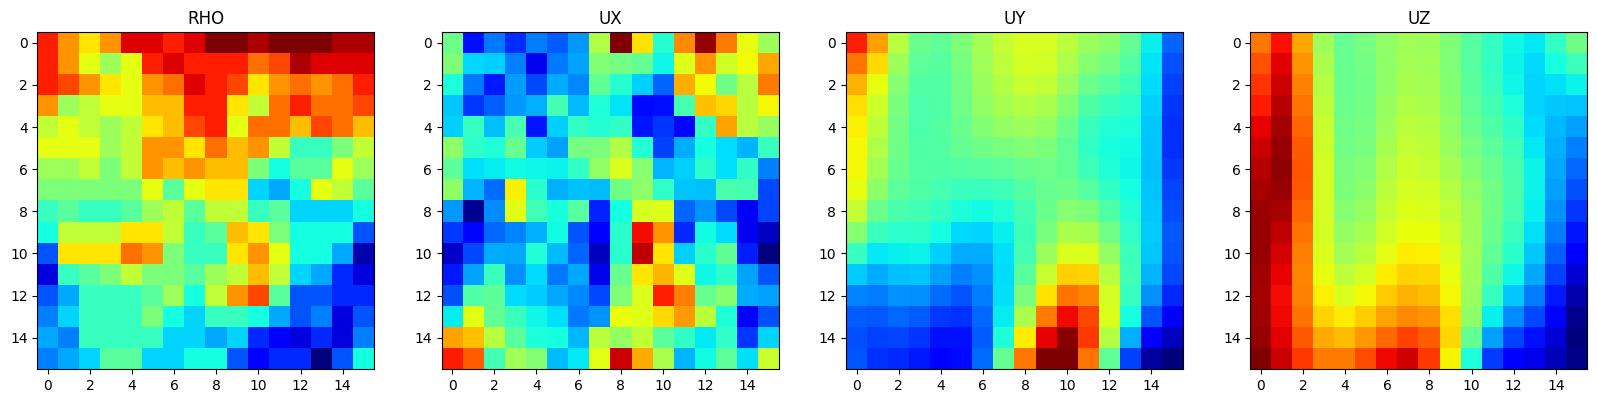

In [35]:
# Now there are only LR test images

# Plot the LR test features

idx = 20
data_path = input_path+"flowfields/LR/test"
RHO_filename = test_df['rho_filename'][idx]
UX_filename = test_df['ux_filename'][idx]
UY_filename = test_df['uy_filename'][idx]
UZ_filename = test_df['uz_filename'][idx]
RHO = np.fromfile(data_path + "/" + RHO_filename, dtype="<f4")
UX = np.fromfile(data_path + "/" + UX_filename, dtype="<f4")

fig, axs = plt.subplots(1, 4, figsize=(20, 5))
axs[0].imshow(RHO.reshape(16, 16), cmap='jet')
axs[0].set_title('RHO')
axs[1].imshow(UX.reshape(16, 16), cmap='jet')
axs[1].set_title('UX')
axs[2].imshow(UY.reshape(16, 16), cmap='jet')
axs[2].set_title('UY')
axs[3].imshow(UZ.reshape(16, 16), cmap='jet')
axs[3].set_title('UZ')



In [36]:
# Set up the Data Pipeline

# Data Loader
def getXY(idx,csv_file,mode = "test"):
    LR_path = input_path + "flowfields/LR/" + mode
    #input
    rho_i = np.fromfile(LR_path + "/" + csv_file['rho_filename'][idx], dtype="<f4").reshape(16,16)
    ux_i = np.fromfile(LR_path + "/" + csv_file['ux_filename'][idx], dtype="<f4").reshape(16,16)
    uy_i = np.fromfile(LR_path + "/" + csv_file['uy_filename'][idx], dtype="<f4").reshape(16,16)
    uz_i = np.fromfile(LR_path + "/" + csv_file['uz_filename'][idx], dtype="<f4").reshape(16,16)
    
    X = tf.stack([rho_i,ux_i,uy_i,uz_i],axis=2)
    
    return X


In [37]:
def getTestXY(idx):
    return getXY(idx,test_df.reset_index().to_dict(orient='list'),mode = "test")

nfile = len(test_df)
X_test = []

# Process the data in batches to avoid Resource Allocation Error

for i in range(nfile):
    X = getTestXY(i)
    X_test.append(X)
X_test = tf.stack(X_test)
X_mean = tf.reduce_mean(X_test,axis=0)
X_std = tf.math.reduce_std(X_test,axis=0)
X_mean.shape,X_std.shape


(TensorShape([16, 16, 4]), TensorShape([16, 16, 4]))

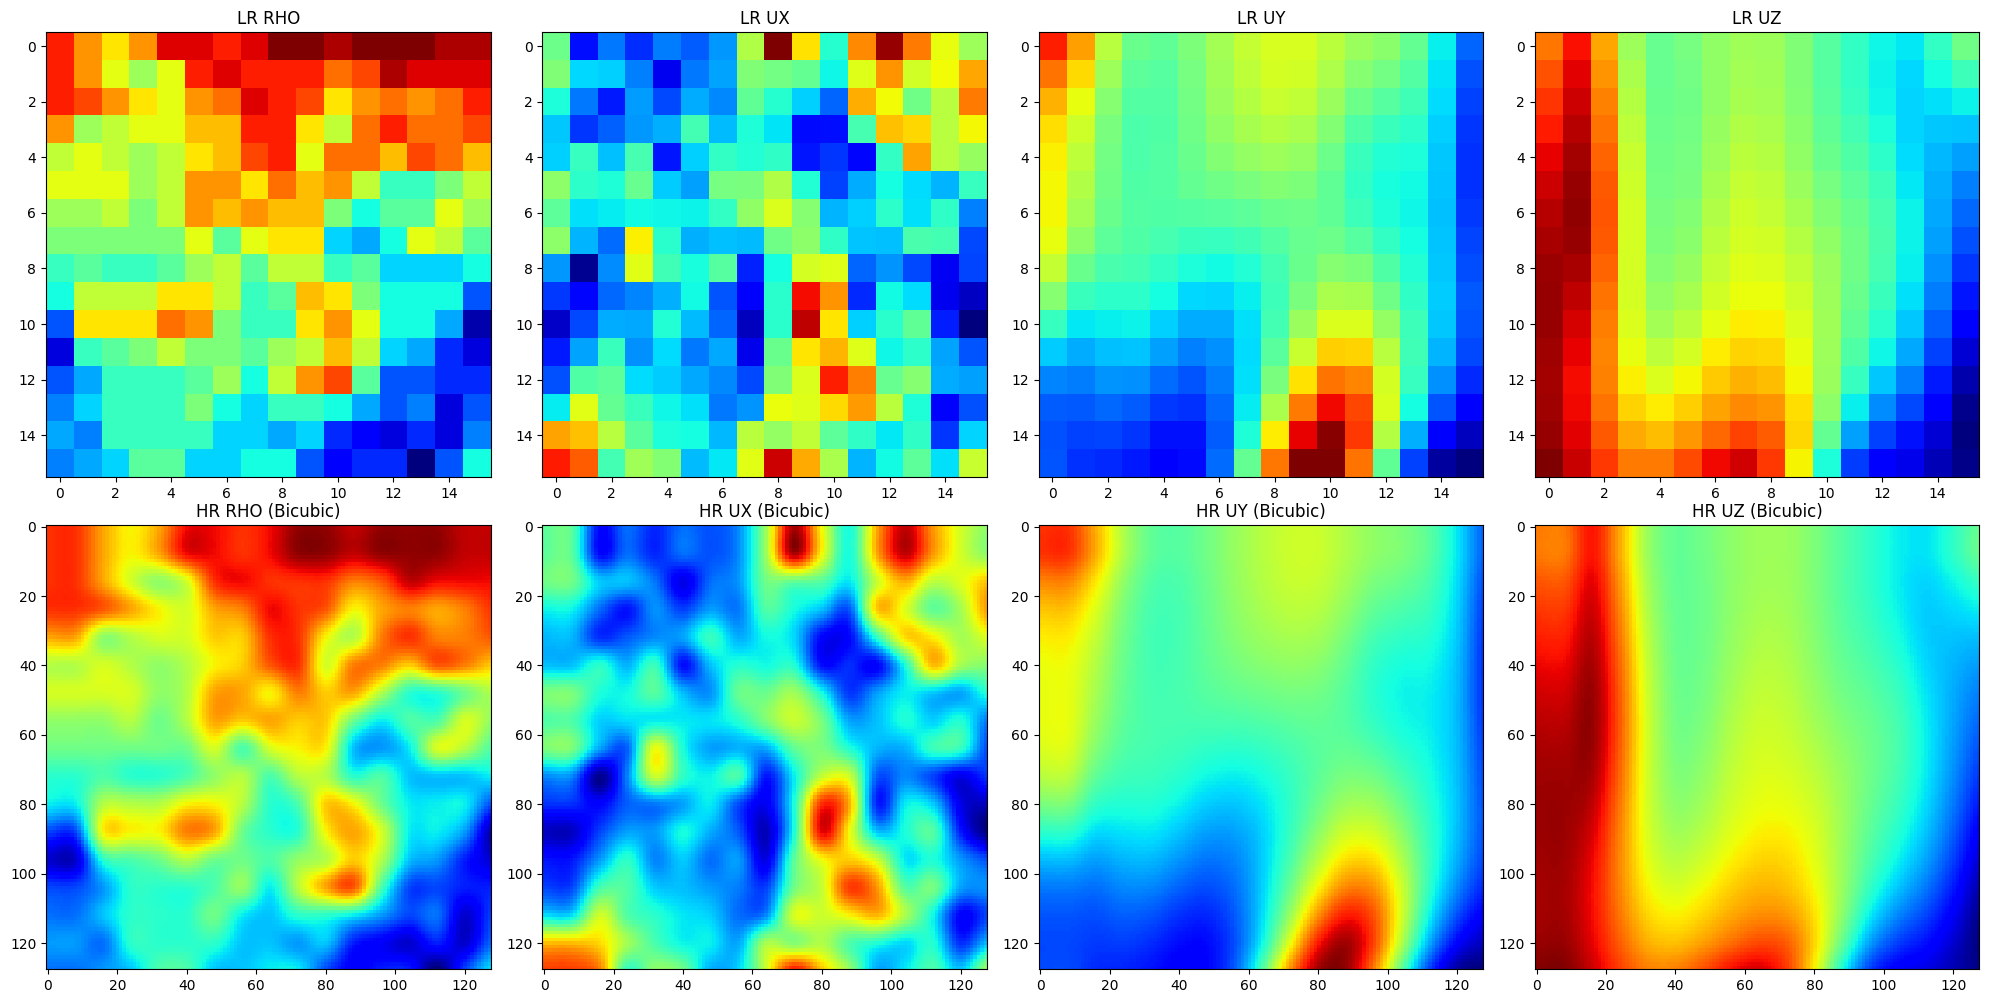

In [ ]:
scale_factor = 8  # From 16x16 to 128x128

# Load LR images

lr_images = [RHO, UX, UY, UZ]
lr_images = [img.reshape(16, 16) for img in lr_images]

# Perform Bilinear interpolation
hr_images = [bilinear_interpolation_INTERLINEAR(img, scale_factor) for img in lr_images]

# Visualize results
titles = ['RHO', 'UX', 'UY', 'UZ']
fig, axs = plt.subplots(2, 4, figsize=(20, 10))

for i in range(4):
    axs[0, i].imshow(lr_images[i], cmap='jet')
    axs[0, i].set_title(f'LR {titles[i]}')
    axs[1, i].imshow(hr_images[i], cmap='jet')
    axs[1, i].set_title(f'HR {titles[i]} (Bilinear)')
    
plt.tight_layout()
plt.show()